C:\Users\pmora\AppData\Local\Temp\ipykernel_9268\3757786082.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_dataFrame = pd.read_sql(query, mydb)


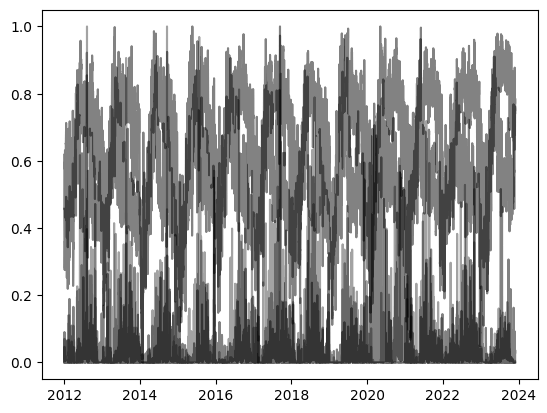

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import calendar
import math
import torch
import torch.nn as nn
import numpy as np
import scipy as sc
from sklearn.preprocessing import MinMaxScaler
from skimage.measure import block_reduce
from sklearn.metrics import mean_absolute_error
import io
import requests
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units
import json

import mysql.connector
from datetime import datetime, timedelta
from sqlalchemy import create_engine

mydb = mysql.connector.connect(
host="localhost",
user="root",
password="pmcm4",
database= "rivercast_model"
)

class initiate_model():

    def __init__(self):
        self.initialize_model()

    def initialize_model(self):

        #IMPORTING
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # configure GPU    utilization

        mydb._open_connection()
        query = "SELECT * FROM rivercast_model.modelData;"
        result_dataFrame = pd.read_sql(query, mydb)


        # Specify the column to exclude (change 'column_to_exclude' to the actual column name)
        column_to_exclude = 'Date_Time'

        # Exclude the specified column
        df = result_dataFrame.drop(column_to_exclude, axis=1, errors='ignore')

        # Print the DataFrame without the excluded column

        # Now 'df' can be used as 'mainDataToDB' or for further processing

        # convert month name to integer

        # create datetime column
        df[['Year', 'Month', 'Day', 'Hour']] = df[['Year', 'Month', 'Day', 'Hour']].astype(int)
        df['Hour'] = df['Hour'].apply(lambda x: x if x < 24 else 0)

        # convert year, month, day, and hour columns into timestamp
        df['Datetime'] = df[['Year', 'Month', 'Day', 'Hour']].apply(lambda row: datetime(row['Year'], row['Month'], row['Day'], row['Hour']).isoformat(), axis=1)
        df["Datetime"] = pd.to_datetime(df["Datetime"], format='ISO8601')

        # assign timestamps as the data frame index
        df.index = df["Datetime"]
        df = df.drop(['Datetime'], axis=1)

        # select the parameters
        df = df[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'Waterlevel.3', 'RF-Intensity', 'RF-Intensity.1', 'RF-Intensity.2', 'RF-Intensity.3', 'Precipitation', 'Precipitation.1', 'Precipitation.2', 'Humidity', 'Humidity.1', 'Humidity.2', 'Temperature', 'Temperature.1', 'Temperature.2']] 
        df = df.astype(np.float64)  # convert parameters into a double precision floating number

        # fill in missing values using linear interpolation
        df = df.interpolate(method='linear', limit_direction='forward')
        df = df.resample('6H').max() # resample dataset using the max value for each 24-hours
        df = df.rolling(12).mean().dropna()
        self.sampling = df

        self.rawData = df

        self.dataset_min = df.min()
        self.dataset_max = df.max()

        df = (df - self.dataset_min) / (self.dataset_max - self.dataset_min)

        #PCA AND EUCLIDEAN KERNEL

        # center data
        rainfall_df = df[['RF-Intensity', 'RF-Intensity.1', 'RF-Intensity.2', 'RF-Intensity.3']]

        plt.plot(rainfall_df, color='k', alpha=0.2)

        # calculate pairwise squared Euclidean distances
        sq_dists = sc.spatial.distance.pdist(rainfall_df.values.T, 'sqeuclidean')

        # convert pairwise distances into a square matrix
        mat_sq_dists = sc.spatial.distance.squareform(sq_dists)

        # compute the symmetric kernel matrix.
        gamma = 1 / len(rainfall_df.columns)
        K = np.exp(-gamma * mat_sq_dists)

        # center the kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # calculate eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(K)

        # calculate components
        rainfall_df = np.matmul(rainfall_df, eigenvectors) 
        rainfall_df = rainfall_df.iloc[:, 1]

        # center data
        precipitation_df = df[['Precipitation', 'Precipitation.1', 'Precipitation.2']]

        plt.plot(precipitation_df, color='k', alpha=0.2)

        # calculate pairwise squared Euclidean distances
        sq_dists = sc.spatial.distance.pdist(precipitation_df.values.T, 'sqeuclidean')

        # convert pairwise distances into a square matrix
        mat_sq_dists = sc.spatial.distance.squareform(sq_dists)

        # compute the symmetric kernel matrix.
        gamma = 1/len(precipitation_df.columns)
        K = np.exp(-gamma * mat_sq_dists)

        # center the kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # calculate eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(K)

        # calculate components
        precipitation_df = np.matmul(precipitation_df, eigenvectors) 
        precipitation_df = precipitation_df.iloc[:, 1]

        # center data
        humidity_df = df[['Humidity', 'Humidity.1', 'Humidity.2']]

        plt.plot(humidity_df, color='k', alpha=0.2)

        # calculate pairwise squared Euclidean distances
        sq_dists = sc.spatial.distance.pdist(humidity_df.values.T, 'sqeuclidean')

        # convert pairwise distances into a square matrix
        mat_sq_dists = sc.spatial.distance.squareform(sq_dists)

        # compute the symmetric kernel matrix.
        gamma = 1/len(humidity_df.columns)
        K = np.exp(-gamma * mat_sq_dists)

        # center the kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # calculate eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(K)

        # calculate components
        humidity_df = np.matmul(humidity_df, eigenvectors) 
        humidity_df = humidity_df.iloc[:, 1]

        # center data
        temp_df = df[['Temperature', 'Temperature.1', 'Temperature.2']]

        plt.plot(temp_df, color='k', alpha=0.2)

        # calculate pairwise squared Euclidean distances
        sq_dists = sc.spatial.distance.pdist(temp_df.values.T, 'sqeuclidean')

        # convert pairwise distances into a square matrix
        mat_sq_dists = sc.spatial.distance.squareform(sq_dists)

        # compute the symmetric kernel matrix.
        gamma = 1/len(temp_df.columns)
        K = np.exp(-gamma * mat_sq_dists)

        # center the kernel matrix.
        N = K.shape[0]
        one_n = np.ones((N, N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # calculate eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(K)

        # calculate components
        temp_df = np.matmul(temp_df, eigenvectors) 
        temp_df = temp_df.iloc[:, 1]

        weather_df = pd.concat([rainfall_df, precipitation_df, humidity_df, temp_df], axis=1)
        weather_df.columns = ['Rainfall', 'Precipitation', 'Humidity', 'Temperature']

        river_df = df[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'Waterlevel.3']]
        self.reduced_df = pd.concat([river_df, weather_df], axis=1)

        self.cleanData = self.reduced_df

        mydb.close()

initiate_model_instance = initiate_model()

BATCH_SIZE = 128
SEQ_LEN = 180
SEQ_STEP = 60
PRED_SIZE = 8
D_MODEL = 8
NUM_HEADS = 4
D_FF = 2048 

# neural network functions
def linear_activation(input, weights, biases):
    batch_size, seq_length, d_model = input.shape  # extract input shape
    
    x_flat = np.reshape(input, (batch_size * seq_length, d_model))  # flatten input into (batch_size, d_model)
    z_flat = np.dot(x_flat, weights.T) + biases
    
    return np.reshape(z_flat, (batch_size, seq_length, -1))  # reshape back to (batch_size, seq_length, d_model)


def relu(input):
    batch_size, seq_length, d_model = input.shape  # extract input shape
    
    x_flat = np.reshape(input, (batch_size * seq_length, d_model))  # flatten input into (batch_size, d_model)
    a_flat = np.maximum(x_flat, 0) 
    
    return np.reshape(a_flat, (batch_size, seq_length, -1))  # reshape back to (batch_size, seq_length, d_model)


def sigmoid(input):
    batch_size, seq_length, d_model = input.shape  # extract input shape
    
    x_flat = np.reshape(input, (batch_size * seq_length, d_model))  # flatten input into (batch_size, d_model)
    a_flat = 1 / (1 + np.exp(-x_flat))
    
    return np.reshape(a_flat, (batch_size, seq_length, -1))  # reshape back to (batch_size, seq_length, d_model)


def softmax(input):
    batch_size, seq_length, d_model = input.shape
    
    x_flat = np.reshape(input, (batch_size * seq_length, d_model)).T  # flatten input into (batch_size, d_model)
    a_flat = np.exp(x_flat) / (np.sum(np.exp(x_flat), axis=0) + 1e-8)
    
    return np.reshape(a_flat.T, (batch_size, seq_length, -1))  # reshape back to (batch_size, seq_length, d_model)


def layer_normalization(input, gamma, beta):
    mean = np.mean(input, axis=-1, keepdims=True)  # get mean in each axis
    std = np.std(input, axis=-1, keepdims=True)  # get standard deviation in each axis
    
    normalized = (input - mean) / (std + 1e-8)  # normalized activations 
    
    # reshape parameters to fit the input shape
    gamma = np.reshape(gamma, (1, 1, -1))
    beta = np.reshape(beta, (1, 1, -1))
    
    return gamma * normalized + beta  # normalized activations with size of (batch_size, seq_length, d_model)


# positional encoding
def positional_encoding(input, n=10000):
    batch_size, seq_length, d_model = input.shape
    
    pe = np.zeros(shape=(seq_length, d_model))
    for k in range(seq_length):
        for i in np.arange(int(d_model / 2)):
            denominator = np.power(n, 2 * i / d_model)
            pe[k, 2*i] = np.sin(k / denominator)
            pe[k, 2*i+1] = np.cos(k / denominator)
            
    return input + pe  # add positional encoding to input

# multi-head attention
def split_heads(input, num_heads):
    batch_size, seq_length, d_model = input.shape
    
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    head_dim = d_model // num_heads
    
    heads = np.reshape(input, (batch_size, seq_length, num_heads, head_dim))
    heads = np.transpose(heads, (0, 2, 1, 3))
    
    return heads  # attention heads with size of (batch_size, num_heads, seq_length, head_dim)


def combine_heads(input):
    combined = np.transpose(input, (0, 2, 1, 3))
    combined = np.reshape(combined, (combined.shape[0], combined.shape[1], -1))
    
    return combined  # combined attention heads with size of (batch_size, seq_length, d_model)


def scaled_dot_product_attention(query, key, value):
    batch_size, num_heads, seq_length, head_dim = query.shape
    
    # convert input into (batch_size, seq_length, d_model)
    query = np.reshape(query, (batch_size * num_heads, seq_length, head_dim))  
    key = np.reshape(key, (batch_size * num_heads, seq_length, head_dim))
    value = np.reshape(value, (batch_size * num_heads, seq_length, head_dim))
    
    key = np.transpose(key, (0, 2, 1))  # transpose key
    attn_scores = np.matmul(query, key) / math.sqrt(head_dim)  # get dot product attention
    
    # generate auto-regressive mask
    attn_scores = np.ma.array(attn_scores, mask=np.triu(np.ones(shape=(batch_size * num_heads, seq_length, seq_length)), k=1))
    attn_scores = attn_scores.filled(fill_value=-1e9)
    
    attn_scores = softmax(attn_scores)  # convert attention scores into probabilities
    
    value = np.matmul(attn_scores, value)  # embed attention scores into value
    
    return np.reshape(attn_scores, (batch_size, num_heads, seq_length, seq_length)), np.reshape(value, (batch_size, num_heads, seq_length, head_dim))  # reshape to original size


def multi_head_self_attention(query, key, value, num_heads, params):
    query = split_heads(linear_activation(query, params[0], params[1]), num_heads)
    key = split_heads(linear_activation(key, params[2], params[3]), num_heads)
    value = split_heads(linear_activation(value, params[4], params[5]), num_heads)
    
    attn_scores, attn_output = scaled_dot_product_attention(query, key, value)
    attn_output = linear_activation(combine_heads(attn_output), params[6], params[7])
    
    return attn_scores, attn_output

# feed forward network
def feed_forward_network(input, params):
    out = linear_activation(input, params[0], params[1])
    out = relu(out)
    out = linear_activation(out, params[2], params[3])
    
    return out

# decoder layer
def transformer_decoder(input, num_heads, params):
    attn_scores, attn_out = multi_head_self_attention(
        query=input,
        key=input, 
        value=input, 
        num_heads=num_heads, 
        params=params[:8])
    norm1 = layer_normalization(input + attn_out, params[12], params[13])
    ff_out = feed_forward_network(norm1, params[8:12])
    norm2 = layer_normalization(norm1 + ff_out, params[14], params[15])
    
    return attn_scores, norm2

# model
def transformer(input, num_heads, params):
    out = positional_encoding(input)
    
    # decoder layers
    _, out = transformer_decoder(out, num_heads, params[:16])
    scores, out = transformer_decoder(out, num_heads, params[16:32])
    
    # final layer
    out = linear_activation(out, params[32], params[33])
    out = sigmoid(out)
    
    return scores, out

# load parameters from file
with open("rivercast_parameters_test.json", "r") as parameters:
    saved_params = json.load(parameters)
    
# iterate through layer parameters
params = []
for key in saved_params.keys():
    param = np.asarray(saved_params[key], dtype=np.float32)  # convert saved parameters back to numpy
    params.append(param)
    
len(params)  # print number of layer parameters




def inverse_transform(data):
    data_min = initiate_model_instance.dataset_min[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'Waterlevel.3']].to_numpy()
    data_max = initiate_model_instance.dataset_max[['Waterlevel', 'Waterlevel.1', 'Waterlevel.2', 'Waterlevel.3']].to_numpy()
    
    return (data_max - data_min) * data + data_min


def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


In [81]:
initiate_model_instance.reduced_df['2020-11-11':'2020-11-15']

,Waterlevel,Waterlevel.1,Waterlevel.2,Waterlevel.3,Rainfall,Precipitation,Humidity,Temperature
Datetime,,,,,,,,
2020-11-11 00:00:00,0.498463,0.118353,0.118353,0.097794,0.161206,0.202280,0.798912,0.466653
2020-11-11 06:00:00,0.731319,0.198030,0.198030,0.123192,0.256464,0.284022,0.786792,0.467688
2020-11-11 12:00:00,0.731587,0.198836,0.198836,0.123061,0.278446,0.441730,0.804848,0.451326
2020-11-11 18:00:00,0.787729,0.213071,0.213071,0.133487,0.414006,0.566119,0.776156,0.426471
2020-11-12 00:00:00,0.663147,0.186213,0.186213,0.134488,0.256464,0.551014,0.791244,0.437448
2020-11-12 06:00:00,0.663147,0.186303,0.186303,0.134154,0.186852,0.541093,0.789760,0.416943
2020-11-12 12:00:00,0.895736,0.265443,0.265443,0.159351,0.172197,0.423664,0.786792,0.392916
2020-11-12 18:00:00,0.995188,0.315577,0.315577,0.174021,0.032974,0.297497,0.824635,0.406379
2020-11-13 00:00:00,0.936105,0.294091,0.294091,0.174021,0.032974,0.167037,0.824635,0.402237


In [82]:
test_data = initiate_model_instance.reduced_df['2020-01-01':'2021-01-01'].values
dataset_len = len(test_data) - (SEQ_LEN + SEQ_STEP) + 1

# prepare batches
batches = []
for index in range(dataset_len):
    in_start = index
    in_end = in_start + SEQ_LEN
    out_start = index + SEQ_STEP
    out_end = out_start + SEQ_LEN
    
    input = test_data[in_start:in_end]
    label = test_data[out_start:out_end]
    
    batches.append((np.array(input), np.array(label)))

In [83]:
# measure accuracy of each window
accuracy = []
predictions = []
for input, label in batches:
    
    input = np.reshape(input, (1, SEQ_LEN, D_MODEL))
    scores, pred = transformer(input=input, num_heads=NUM_HEADS, params=params)  # make forecast
    pred = np.reshape(pred, (SEQ_LEN, D_MODEL))  
    pred = inverse_transform(pred[:, :4])  # scale output to original value
    pred = pred[-SEQ_STEP:]   # get only the forecast window
    
    ground = inverse_transform(label[:, :4])  # scale output to original value
    ground = ground[-SEQ_STEP:]  # get only the forecast window
    
    accuracy.append(mean_absolute_error(ground, pred))  # collect mean absolute error of each window
    predictions.append(np.concatenate((pred[0], ground[0])))  # collect first element of output

    
accuracy_df = pd.DataFrame(np.array(accuracy), columns=['MAE'])
predictions_df = pd.DataFrame(np.array(predictions), columns=['P_Waterlevel', 'P_Waterlevel.1', 'P_Waterlevel.2', 'P_Waterlevel.3', 'T_Waterlevel', 'T_Waterlevel.1', 'T_Waterlevel.2', 'T_Waterlevel.3'])
metric_df = pd.concat([accuracy_df, predictions_df], axis=1)
metric_df.index = initiate_model_instance.sampling.index[-len(metric_df):]

metric_df = metric_df.resample('24H').max()



In [79]:
metric_df.to_csv('test_data.csv')

In [84]:
print('Average Mean Absolute Error:', metric_df['MAE'].mean())
print('Mean Absolute Error STD:', metric_df['MAE'].std())

Average Mean Absolute Error: 7.151691430835991
Mean Absolute Error STD: 1.2136372451418833


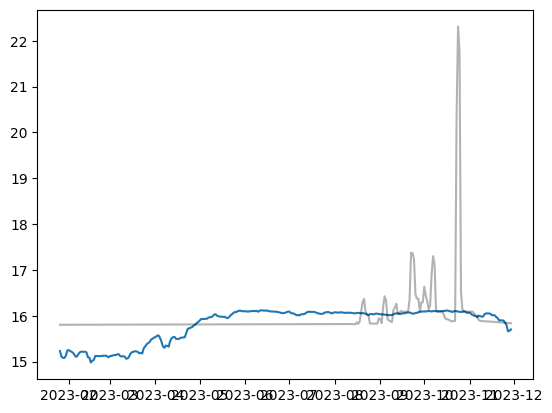

: 

In [86]:
plt.plot(metric_df['P_Waterlevel'])  # plot predictions
plt.plot(metric_df['T_Waterlevel'], color='k', alpha=0.3)  # plot observed value
plt.show()